In [1]:
from datasets import load_dataset
from transformers import pipeline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

SEED=1

## Loading the data

In [2]:
special_labels = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence']

In [3]:
data = load_dataset("train/audio", name="en-US", split='train')
data = data.train_test_split(test_size=0.2, seed=SEED)

Resolving data files:   0%|          | 0/65123 [00:00<?, ?it/s]

In [4]:
all_labels = data["train"].features["label"].names

label2id, id2label = dict(), dict()

for i, label in enumerate(all_labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

special_ids = [int(label2id[label]) for label in special_labels]

In [5]:
def get_confusion_matrix(classifier, audio, true_labels, all_labels):
    predicted = classifier(audio)
    predicted_labels = [pred[0]["label"] for pred in predicted]
    conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=all_labels)

    return conf_matrix

def plot_confusion_matrix(matrix, labels, model_name):
    plt.figure(figsize=(15, 7))
    sns.heatmap(matrix, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for model {model_name}')
    plt.show()

def get_true_labels(input):
    return [id2label[str(a)] for a in input["label"]]

In [18]:
def test_one(data, classifier, model_name):
    all_labels_data = data["test"]
    test_conf_matrix = get_confusion_matrix(classifier, all_labels_data["audio"], get_true_labels(all_labels_data), all_labels)
    plot_confusion_matrix(test_conf_matrix, all_labels, model_name)
    
    train_conf_matrix = get_confusion_matrix(classifier, data["train"]["audio"], get_true_labels(data["train"]), all_labels)

    accuracies_test = np.diag(test_conf_matrix) / np.sum(test_conf_matrix, axis=1)
    accuracies_train = np.diag(train_conf_matrix) / np.sum(train_conf_matrix, axis=1)

    bar_width = 0.35

    x = np.arange(len(all_labels))
    positions_series_1 = x - bar_width / 2
    positions_series_2 = x + bar_width / 2

    plt.figure(figsize=(15, 7))
    plt.bar(positions_series_1, accuracies_test, width=bar_width, label="Test")
    plt.bar(positions_series_2, accuracies_train, width=bar_width, label="Train")
    plt.xlabel('Classes')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Per Class')
    plt.xticks(x, all_labels)
    plt.legend()
    plt.ylim(0, 1)
    plt.show()

    train_accuracy = np.trace(train_conf_matrix) / np.sum(train_conf_matrix)
    test_accuracy = np.trace(test_conf_matrix) / np.sum(test_conf_matrix)

    print(f'Overall model train accuracy: {train_accuracy:.2f}')
    print(f'Overall model test accuracy: {test_accuracy:.2f}')

def test_two(data, classifier, model_name):
    filtered_audio_test = []
    filtered_true_labels_test = []
    for pair in data["test"]:
        if id2label[str(pair["label"])] in special_labels:
            filtered_audio_test.append(pair["audio"])
            filtered_true_labels_test.append(id2label[str(pair["label"])])

    filtered_audio_train = []
    filtered_true_labels_train = []
    for pair in data["train"]:
        if id2label[str(pair["label"])] in special_labels:
            filtered_audio_train.append(pair["audio"])
            filtered_true_labels_train.append(id2label[str(pair["label"])])

    test_conf_matrix = get_confusion_matrix(classifier, filtered_audio_test, filtered_true_labels_test, all_labels)
    plot_confusion_matrix(test_conf_matrix, all_labels, model_name)

    train_conf_matrix = get_confusion_matrix(classifier, filtered_audio_train, filtered_true_labels_train, all_labels)

    accuracies_test = np.diag(test_conf_matrix) / np.sum(test_conf_matrix, axis=1)
    accuracies_train = np.diag(train_conf_matrix) / np.sum(train_conf_matrix, axis=1)

    selected_accuracies_test = [accuracies_test[i] for i, label in enumerate(all_labels) if label in special_labels]
    selected_accuracies_train = [accuracies_train[i] for i, label in enumerate(all_labels) if label in special_labels]

    selected_label_names = [label for label in all_labels if label in special_labels]

    bar_width = 0.35

    x = np.arange(len(selected_label_names))
    positions_series_1 = x - bar_width / 2
    positions_series_2 = x + bar_width / 2

    plt.figure(figsize=(15, 7))
    plt.bar(positions_series_1, selected_accuracies_test, width=bar_width, label='Test')
    plt.bar(positions_series_2, selected_accuracies_train, width=bar_width, label='Train')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy')
    plt.xticks(x, selected_label_names)
    plt.title('Accuracy Per Selected Class')
    plt.legend()
    plt.ylim(0, 1)
    plt.show()

    train_accuracy = np.trace(train_conf_matrix) / np.sum(train_conf_matrix)
    test_accuracy = np.trace(test_conf_matrix) / np.sum(test_conf_matrix)

    print(f'Selected model train accuracy: {train_accuracy:.4f}')
    print(f'Selected model test accuracy: {test_accuracy:.4f}')

## Model Wav2Vec

In [11]:
model_name = "wojtek2288/Wav2Vec"
classifier = pipeline("audio-classification", model=model_name)

### Testing the model on all possible classes

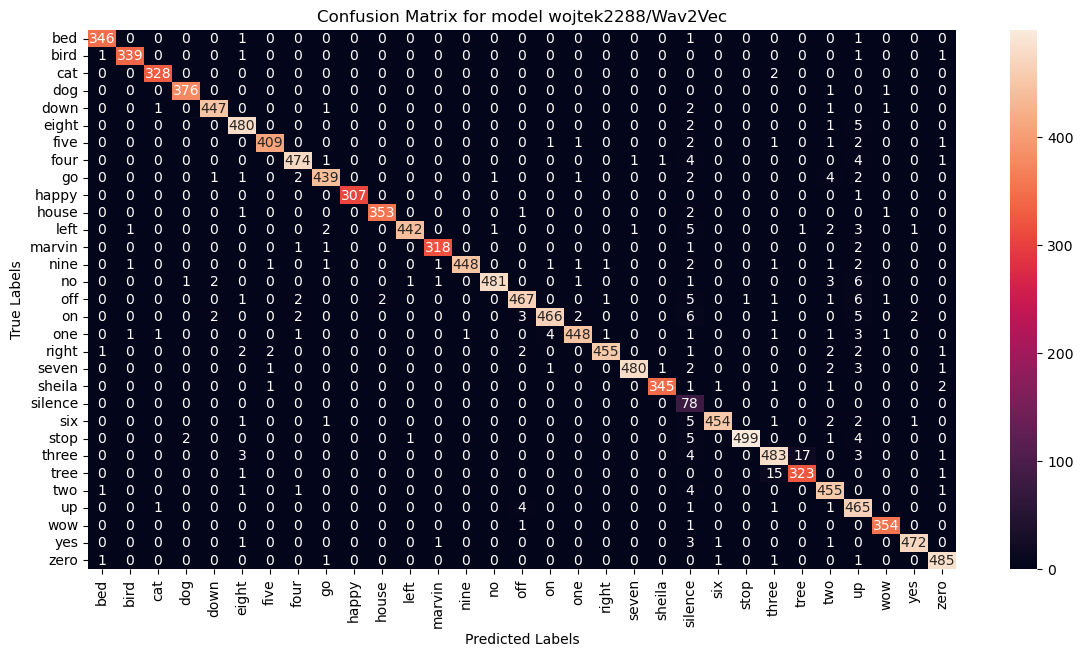

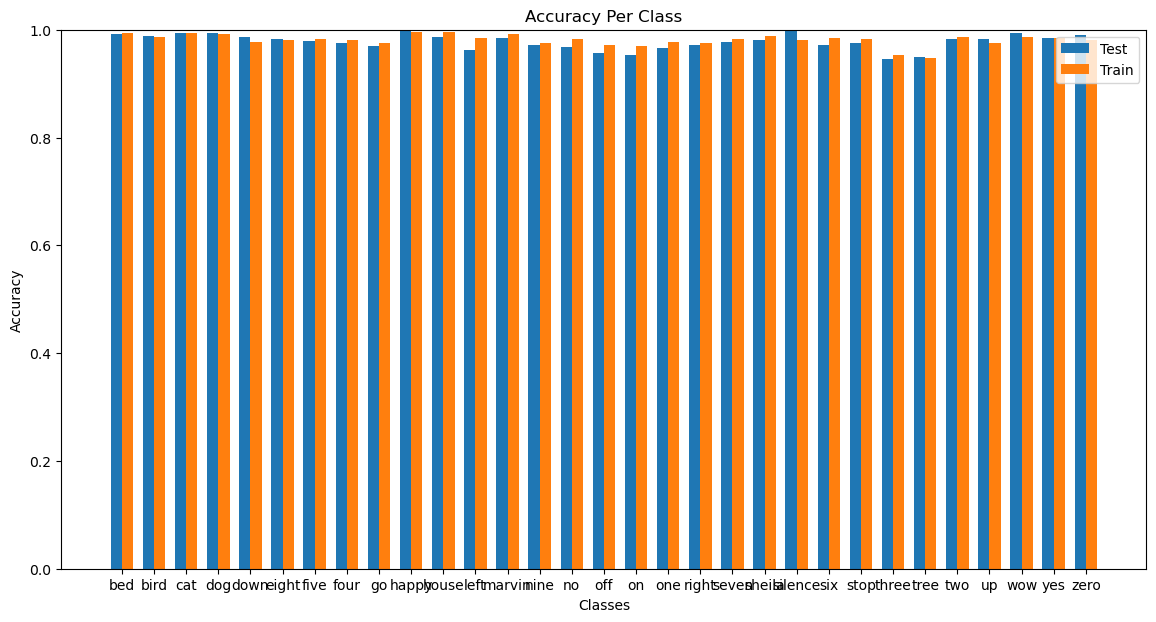

Overall model train accuracy: 0.98
Overall model test accuracy: 0.98


In [12]:
test_one(data, classifier, model_name)

### Testing the model only on data with labels defined in the task

In [19]:
test_two(data, classifier, model_name)

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 52098
    })
    test: Dataset({
        features: ['audio', 'label'],
        num_rows: 13025
    })
})


KeyboardInterrupt: 

## Model HUBERT

In [ ]:
model_name = "wojtek2288/HUBERT"
classifier = pipeline("audio-classification", model=model_name)

### Testing the model on all possible classes

In [ ]:
test_one(data, classifier, model_name)

### Testing the model only on data with labels defined in the task

In [ ]:
test_two(data, classifier, model_name)

## Model Wav2Vec-LR

In [ ]:
model_name = "wojtek2288/Wav2Vec-LR"
classifier = pipeline("audio-classification", model=model_name)

### Testing the model on all possible classes

In [ ]:
test_one(data, classifier, model_name)

### Testing the model only on data with labels defined in the task

In [ ]:
test_two(data, classifier, model_name)

## Model HUBERT-LR

In [ ]:
model_name = "wojtek2288/HUBERT-LR"
classifier = pipeline("audio-classification", model=model_name)

### Testing the model on all possible classes

In [ ]:
test_one(data, classifier, model_name)

### Testing the model only on data with labels defined in the task

In [ ]:
test_two(data, classifier, model_name)

## Load a dataset with unknown labels

In [59]:
data = load_dataset("train-unknown/audio", name="en-US", split='train')
data = data.train_test_split(test_size=0.2, seed=SEED)

Resolving data files:   0%|          | 0/65123 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

## Model Wav2Vec-Unknown

In [60]:
model_name = "wojtek2288/Wav2Vec-Unknown"
classifier = pipeline("audio-classification", model=model_name)

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

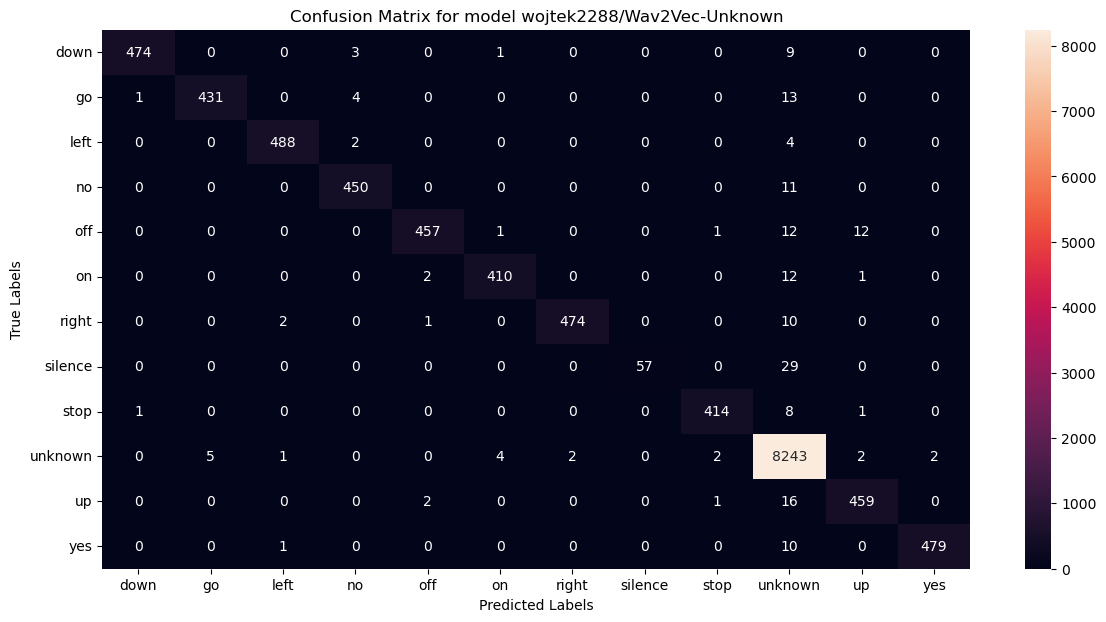

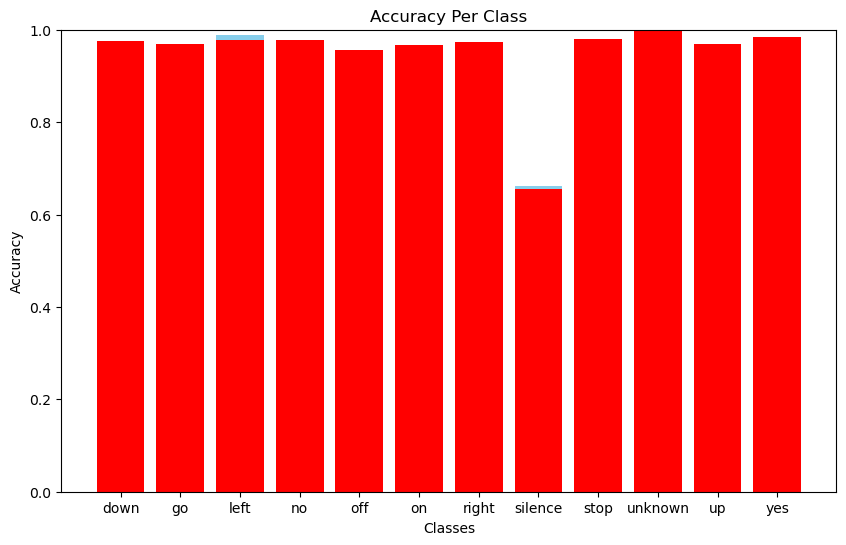

Overall model train accuracy: 0.99
Overall model test accuracy: 0.99


In [68]:
test_one(data, classifier, model_name)

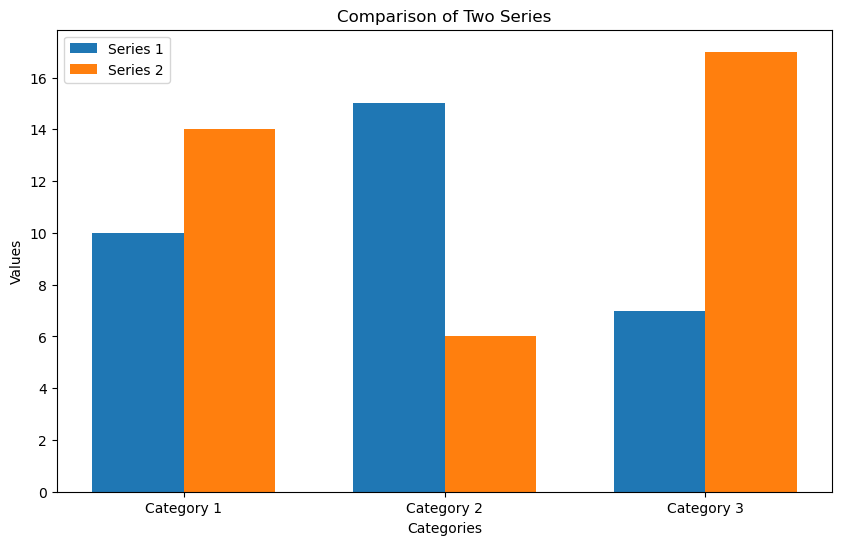

In [72]:
# Sample data
categories = ['Category 1', 'Category 2', 'Category 3']
values_series_1 = [10, 15, 7]
values_series_2 = [14, 6, 17]

# Set the width of the bar
bar_width = 0.35

# Set positions of bars
x = np.arange(len(categories))  # the label locations
positions_series_1 = x - bar_width / 2  # Bars shifted to the left
positions_series_2 = x + bar_width / 2  # Bars shifted to the right

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(positions_series_1, values_series_1, width=bar_width, label='Series 1')
plt.bar(positions_series_2, values_series_2, width=bar_width, label='Series 2')

# Adding labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Comparison of Two Series')
plt.xticks(x, categories)  # Set text labels and properties.

# Adding a legend
plt.legend()

# Display the plot
plt.show()

## Model HUBERT-Unknown

In [ ]:
model_name = "wojtek2288/HUBERT-Unknown"
classifier = pipeline("audio-classification", model=model_name)

In [ ]:
test_one(data, classifier, model_name)